In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

import nltk
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victoriaivanova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train = pd.read_csv('./21vek-query-classification/train.csv')
test = pd.read_csv('./21vek-query-classification/test.csv')

categories = pd.read_csv('./21vek-query-classification/categories.csv')

Данный датасет представляет собой набор данных, содержащая пользовательские запросы и соответствующие категории товаров:   

> `ID` – уникальный идентификатор строки.  

> `Query` – поисковый запрос пользователя на сайте 21vek.by.  

> `CategoryID` – идентификатор товарной категории (целевая переменная, только в **train**).  

> `CategoryName` – название категории (только в справочнике **categories.csv**).


In [4]:
train.head()

,ID,CategoryID,Query
0,1,1,edifier
1,2,2,умная колонка яндекс станция лайт
2,3,3,чехол iphone 14 pro
3,4,4,zte
4,5,5,ноутбук huawei matebook b3-520 53012kfg


In [5]:
categories.head()

,CategoryID,CategoryName
0,0,Монитор
1,1,Мультимедиа акустика
2,2,Портативная акустика
3,3,Чехол/защитное стекло для телефона
4,4,Мобильный телефон


Основная задача:  

Построить модель, которая по тексту запроса `Query` предсказывает `CategoryID`.

## EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11558 entries, 0 to 11557
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          11558 non-null  int64 
 1   CategoryID  11558 non-null  int64 
 2   Query       11558 non-null  object
dtypes: int64(2), object(1)
memory usage: 271.0+ KB


Структура данных:  
- `ID` - числовой признак  

- `CategoryID` - числовой признак  

- `Query` -  текстовый признак

In [6]:
train.isna().sum()

ID            0
CategoryID    0
Query         0
dtype: int64

Пропущенные значения отсутствуют.  

Для лучшего понимания распределения целевых классов `CategoryID` объединим **train** с названиями категорий из **categories** и визуализируем количество примеров в каждой категории с помощью гистограммы.

In [7]:
train_merged = pd.merge(train, categories, on='CategoryID')

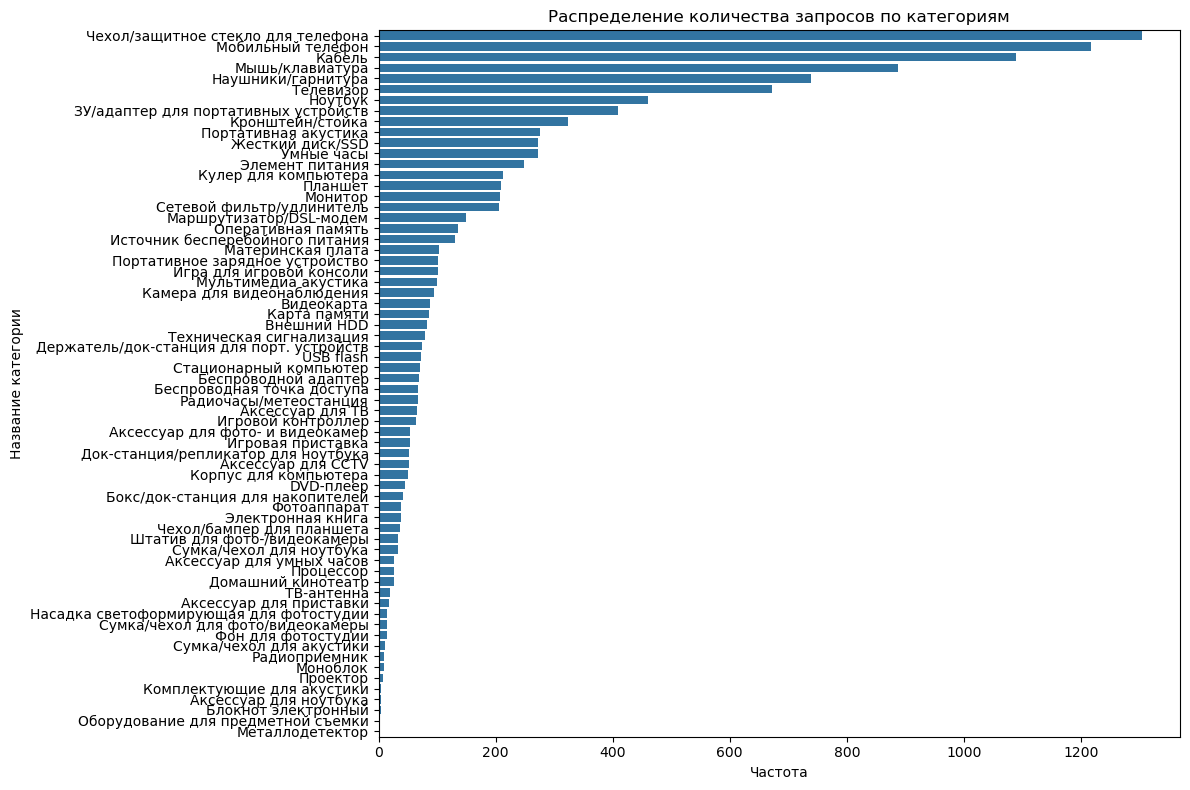

In [8]:
plt.figure(figsize=(12, 8))

sns.countplot(data=train_merged, y='CategoryName', order=train_merged['CategoryName'].value_counts().index)
plt.title('Распределение количества запросов по категориям')
plt.xlabel('Частота')
plt.ylabel('Название категории')
plt.tight_layout()
plt.show()

Построенная гистограмма распределения категорий показывает **существенный дисбаланс** в обучающем датасете. Наибольшее количество запросов приходится на категории, связанные с мобильными телефонами, чехлами и аксессуарами. В то же время, ряд категорий представлены крайне малым числом примеров.

Теперь добавим признак, отражающий **длину запроса в словах**, и проанализируем его распределение в целом и по категориям товаров. 

In [9]:
train_merged['QueryLength'] = train_merged['Query'].apply(lambda word: len(str(word).split()))

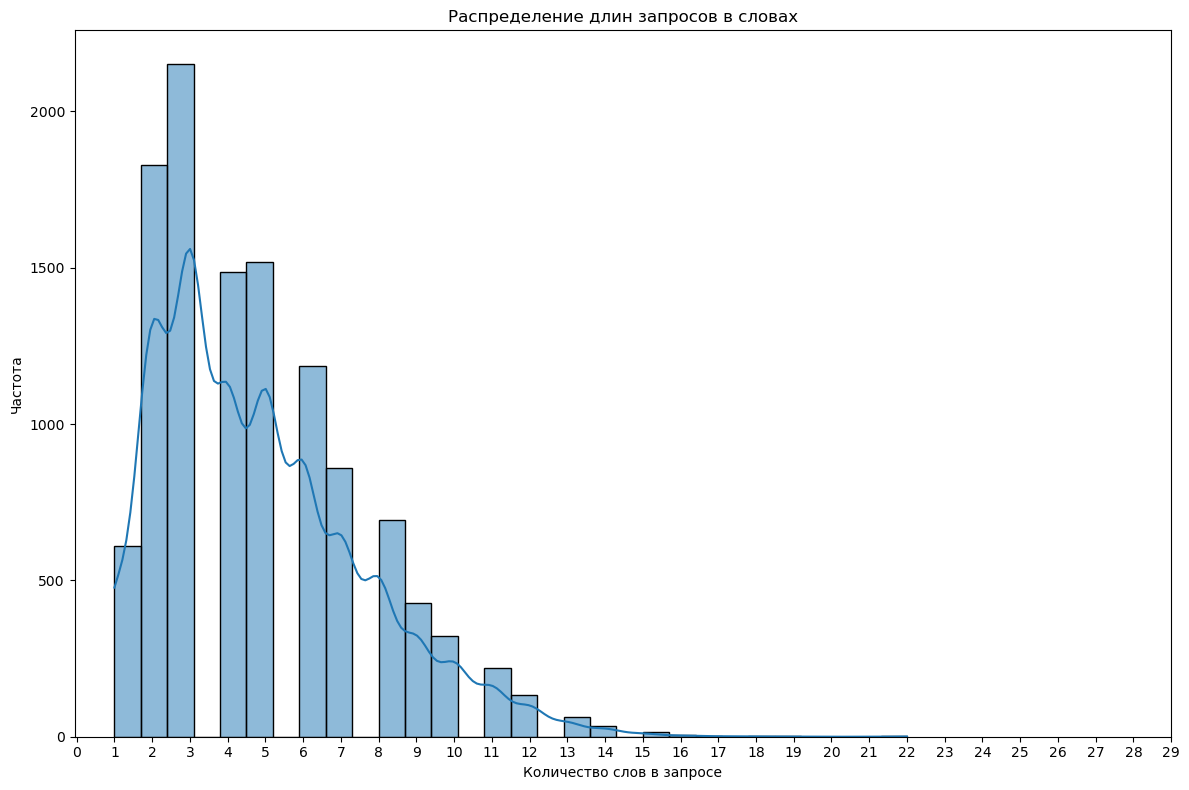

In [10]:
plt.figure(figsize=(12, 8))

sns.histplot(data=train_merged, x='QueryLength', bins=30, kde=True)
plt.title('Распределение длин запросов в словах')
plt.xlabel('Количество слов в запросе')
plt.xticks(np.arange(0, 30))
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Построенная гистограмма показывает, что большая часть запросов содержит от **1 до 3 слов**. Это свидетельствует о том, что пользователи часто формулируют свои намерения кратко. Для многих товаров, такая длина запроса является естественной и достаточной для однозначной классификации, поскольку сам термин уже четко определяет категорию. Таким образом, преобладание коротких запросов не обязательно указывает на недостаток информации для их категоризации, а скорее отражает типичное поведение пользователей при поиске конкретных и общеизвестных товаров.

Следующим шагом будет построение гистограммы длины запросов в разрезе категорий.

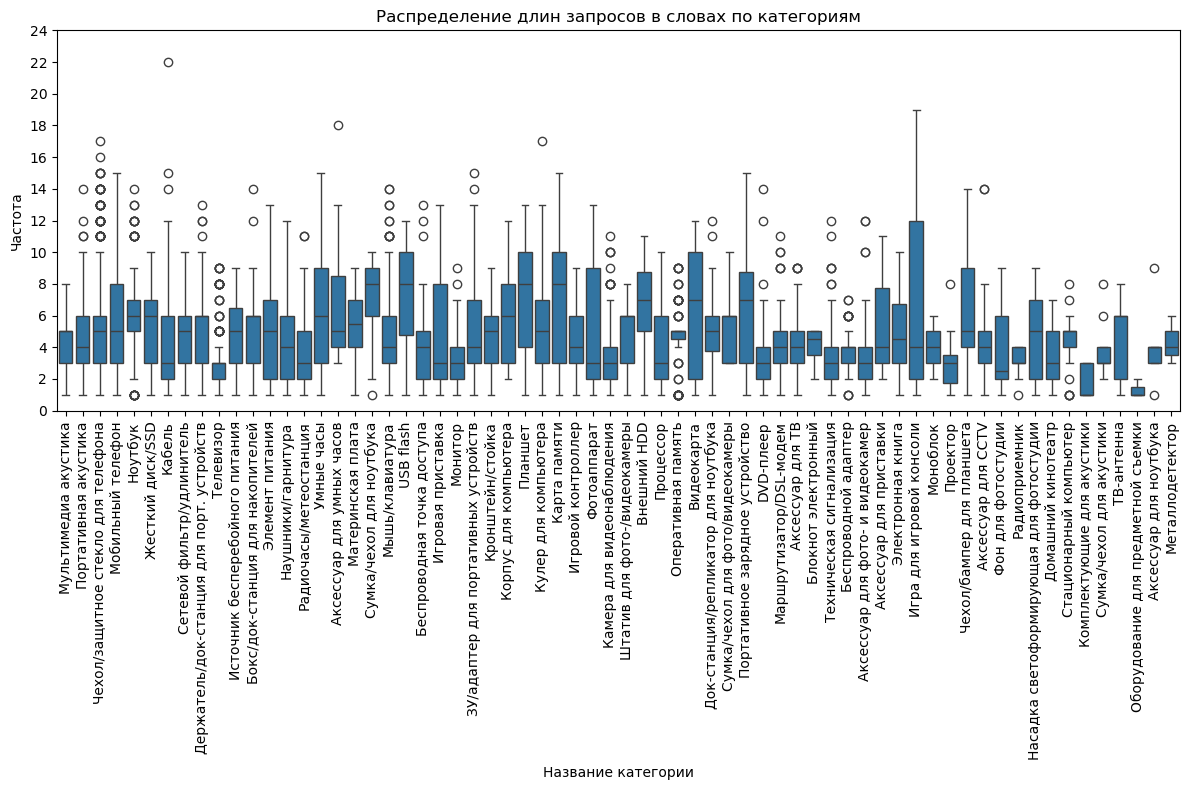

In [11]:
plt.figure(figsize=(12,8))

sns.boxplot(data=train_merged, x='CategoryName', y='QueryLength')
plt.title('Распределение длин запросов в словах по категориям')

plt.xlabel('Название категории')
plt.xticks(rotation=90)

plt.ylabel('Частота')
plt.yticks(np.arange(0, 25, 2))

plt.tight_layout()
plt.show()

Построенный boxplot демонстрирует, что **длина пользовательских запросов значительно варьируется в зависимости от категории товара**. Медианные значения различаются между группами, что указывает на различную специфику формулировки запросов для разных типов товаров.  

Кроме того, в распределении наблюдаются **выбросы**, особенно заметные в категориях, связанных с аксессуарами и комплектующими. Это может указывать на то, что пользователи нередко уточняют технические детали или совместимость товаров, формируя более длинные и информативные запросы.

Для количественной оценки структуры поисковых запросов рассчитаем основные статистические характеристики нового признака `QueryLength`, включая минимальное, максимальное, среднее и медианное значения, а также стандартное отклонение. Это позволит получить более точное представление о типичной длине запросов и определить возможные пороговые значения для последующей обработки текста.

In [12]:
train_merged['QueryLength'].agg(
    ['min', 'max', 'std', 'median', 'mean',
        lambda x: x.quantile(.95)
    ]
).rename({
    '<lambda>': '95%',
    '<lambda_1>': '95%',
})

min        1.000000
max       22.000000
std        2.726544
median     4.000000
mean       4.820644
95%       10.000000
Name: QueryLength, dtype: float64

Рассчитанные статистики по признаку `QueryLength` показали, что в среднем пользовательские запросы содержат около **5 слов**:  
- среднее значение — **4.8**;   
- медиана — **4**.  
- Минимальная длина запроса составляет **1 слово**, а максимальная — **22 слова**.
- **95%** всех запросов содержат **не более 10 слов**.  

## Text preprocessing

Выполним очистку и нормализацию текстовых данных. Этот этап включает приведение текста к нижнему регистру, удаление нерелевантных символов, лемматизацию слов, а также удаление как общеупотребительных, так и специально заданных стоп-слов. Дополнительно из текста удаляются цифры, а также формируется версия запросов, содержащая только ключевые слова-существительные. Все это нацелено на подготовку качественных и однородных текстовых данных для повышения эффективности модели.

Перед удалением стоп-слов проведем анализ частотности слов в запросах. Для этого разобьем все запросы на отдельные слова и подсчитаем количество их вхождений по всему обучающему датасету. Такой анализ позволит выявить наиболее частые слова и определить, какие из них действительно можно считать нерелевантными для классификации, чтобы обоснованно дополнить или скорректировать список стоп-слов.

In [6]:
tokens = train['Query'].apply(lambda query: query.split())

text = [word for query in tokens for word in query]
word_count = Counter(text)
word_count.most_common(30)

[('/', 1743),
 ('для', 1457),
 ('(черный)', 901),
 ('xiaomi', 591),
 ('чехол', 561),
 ('смартфон', 541),
 ('кабель', 521),
 ('pro', 520),
 ('samsung', 486),
 ('iphone', 446),
 ('redmi', 431),
 ('телевизор', 406),
 ('apple', 390),
 ('наушники', 386),
 ('ноутбук', 379),
 ('на', 373),
 ('galaxy', 283),
 ('мышь', 282),
 ('стекло', 255),
 ('зарядное', 246),
 ('адаптер', 241),
 ('беспроводные', 241),
 ('usb', 234),
 ('lg', 227),
 ('defender', 220),
 ('кронштейн', 218),
 ('ssd', 216),
 ('honor', 215),
 ('note', 210),
 ('устройство', 208)]

Проведенный анализ частотности показал, что большинство часто встречающихся слов относятся напрямую к моделям и типам товаров.  
 
Вместе с тем в запросах регулярно встречаются общеупотребительные предлоги, служебные слова (такие как `"для"`, `"на"`) и цвета товаров, которые не добавляют полезной информации для задачи классификации.

In [7]:
common_stopwords = set(stopwords.words('russian'))
custom_stopwords = {'черный', 'белый', 'желтый', 'красный', 'синий', 
                     'фиолетовый', 'зеленый', 'оранжевый', 'голубой', 'для', 'на'}

stop_words = common_stopwords.union(custom_stopwords)

def clean(query):
    query = query.lower()
    query = re.sub(r'\W', ' ', query)
    query = re.sub(r'\s+', ' ', query).strip()
    return query

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

def remove_digits(query):
    query = re.sub(r'\d+', ' ', query)
    return query

def lemmatization(tokens):
    return [morph.parse(word)[0].normal_form for word in tokens ]

morph = MorphAnalyzer()

In [8]:
train['CleanedText'] = train['Query'].apply(clean)
train['CleanedText'] = train['CleanedText'].apply(lambda query: lemmatization(query.split()))
train['CleanedText'] = train['CleanedText'].apply(remove_stopwords)

In [9]:
keywords_by_category = defaultdict(set)

for category in train['CategoryID'].unique():
    category_tokens = train[train['CategoryID'] == category]['CleanedText'].explode()
    count_tokens = Counter(category_tokens)

    top_words = [word for word, count in count_tokens.most_common(20)]

    top_nouns = []
    for word in top_words:
        if not isinstance(word, str) or not word:
            continue
        parsed_word = morph.parse(word)
        if parsed_word:
            best_parse = parsed_word[0]
            if 'NOUN' in best_parse.tag:
                top_nouns.append(word)

    if top_nouns:
      keywords_by_category[category].update(top_nouns)

all_keywords = set()
for keywords in keywords_by_category.values():
    all_keywords.update(keywords)

print(f"Итого уникальных ключевых слов (только существительные): {len(all_keywords)}")

def retain_keywords(tokens, all_keywords_set):
    keywords = [token for token in tokens if token in all_keywords_set]
    if not keywords:
        return tokens
    return keywords

Итого уникальных ключевых слов (только существительные): 169


In [10]:
train['KeyWords'] = train['CleanedText'].apply(lambda tokens: retain_keywords(tokens, all_keywords))

In [11]:
train['QueryLength'] = [len(query) for query in train['CleanedText']]
train[train['QueryLength'] == 0].shape[0]

0

In [12]:
train['KeyWords'] = train['KeyWords'].apply(lambda tokens: ' '.join(tokens))
train['CleanedText'] = train['CleanedText'].apply(lambda tokens: ' '.join(tokens))
train['CleanedText'] = train['CleanedText'].apply(remove_digits)

In [13]:
train.head()

,ID,CategoryID,Query,CleanedText,KeyWords,QueryLength
0,1,1,edifier,edifier,edifier,1
1,2,2,умная колонка яндекс станция лайт,умный колонка яндекс станция лайта,колонка яндекс станция,5
2,3,3,чехол iphone 14 pro,чехол iphone pro,чехол,4
3,4,4,zte,zte,zte,1
4,5,5,ноутбук huawei matebook b3-520 53012kfg,ноутбук huawei matebook b kfg,ноутбук,6


Все этапы подготовки данных завершены: проведен анализ структуры и распределения данных, выполнена очистка и нормализация текстов, а также сформированы признаки, готовые для подачи в модель.

## Model 

In [14]:
X_train_text, X_valid_text, X_train_keys, X_valid_keys, y_train, y_valid = train_test_split(
    train['CleanedText'],
    train['KeyWords'],
    train['CategoryID'],
    test_size=0.2,
    stratify=train['CategoryID'],
    random_state=42
)

vectorizer_full = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
vectorizer_keys = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

X_train_full_vec = vectorizer_full.fit_transform(X_train_text)
X_train_keys_vec = vectorizer_keys.fit_transform(X_train_keys)
X_train_combined = hstack([X_train_full_vec, X_train_keys_vec])

X_valid_full_vec = vectorizer_full.transform(X_valid_text)
X_valid_keys_vec = vectorizer_keys.transform(X_valid_keys)
X_valid_combined = hstack([X_valid_full_vec, X_valid_keys_vec])

В качестве первой базовой модели для классификации текстов используем **Multinomial Naive Bayes**. Эта модель служит отправной точкой для оценки качества без дополнительных мер по балансировке данных.

In [15]:
mnb = MultinomialNB()

mnb.fit(X_train_combined, y_train)
y_mnb = mnb.predict(X_valid_combined)
macro_f1_mnb = f1_score(y_valid, y_mnb, average='macro')
print(f'Macro F1-score on validation for Multinomial Naive Bayes: {macro_f1_mnb:.4f}')

Macro F1-score on validation for Multinomial Naive Bayes: 0.6691


Следующим этапом обучим модель **Logistic Regression** с параметром `class_weight='balanced'`, который позволяет автоматически взвешивать классы обратно пропорционально их частоте. 

In [16]:
logisitic = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

logisitic.fit(X_train_combined, y_train)
y_log = logisitic.predict(X_valid_combined)
macro_f1_log = f1_score(y_valid, y_log, average='macro')
print(f'Macro F1-score on validation for Logistic Regression: {macro_f1_log:.4f}')

Macro F1-score on validation for Logistic Regression: 0.8644


Для дополнительной проверки влияния балансировки данных применим метод **SMOTE**, который позволяет увеличить количество примеров для редких классов за счет синтетических примеров. 

In [17]:
smote = SMOTE(k_neighbors=1, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

In [18]:
logisitic.fit(X_train_resampled, y_train_resampled)
y_log = logisitic.predict(X_valid_combined)
macro_f1_log = f1_score(y_valid, y_log, average='macro')
print(f'Macro F1-score on validation for Logistic Regression (SMOTE): {macro_f1_log:.4f}')

Macro F1-score on validation for Logistic Regression (SMOTE): 0.8855


После применения **SMOTE** для балансировки обучающей выборки **Macro F1-score** модели **Logistic Regression** составил **0.8855**, что демонстрирует прирост по сравнению с вариантом с автоматической балансировкой весов классов.   

Теперь подберём гиперпараметр `C` для модели логистической регрессии с помощью **GridSearchCV**.



In [19]:
param = {
    'C': np.logspace(-2, 2, 10),
}

grid_log = GridSearchCV(
    estimator=logisitic,
    param_grid=param,
    scoring='f1_macro',
    n_jobs=-1
)

grid_log.fit(X_train_resampled, y_train_resampled)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='f1_macro')

In [20]:
grid_log.best_params_

{'C': 4.6415888336127775}

In [21]:
logistic_grid = grid_log.best_estimator_

logistic_grid.fit(X_train_resampled, y_train_resampled)
y_hat = logistic_grid.predict(X_valid_combined)
f1_score = f1_score(y_valid, y_hat, average='macro')
print(f1_score)

0.8836108245180531


После выбора наилучшей модели обучим **Logistic Regression** на всём обучающем наборе данных и выполним предсказания для тестовой выборки, чтобы получить итоговые результаты классификации для новых данных.



## Test Data

In [48]:
test['CleanedText'] = test['Query'].apply(clean)
test['CleanedText'] = test['CleanedText'].apply(lambda query: lemmatization(query.split()))
test['CleanedText'] = test['CleanedText'].apply(lambda q: remove_stopwords(q))

test['KeyWords'] = test['CleanedText'].apply(lambda tokens: retain_keywords(tokens, all_keywords))

test['KeyWords'] = test['KeyWords'].apply(lambda tokens: ' '.join(tokens))
test['CleanedText'] = test['CleanedText'].apply(lambda tokens: ' '.join(tokens))

test['CleanedText'] = test['CleanedText'].apply(remove_digits)

In [ ]:
X_full_all = vectorizer_full.fit_transform(train['CleanedText'])
X_keys_all = vectorizer_keys.fit_transform(train['KeyWords'])
X_train_all_combined = hstack([X_full_all, X_keys_all])

X_test_full_vec = vectorizer_full.transform(test['CleanedText'])
X_test_keys_vec = vectorizer_keys.transform(test['KeyWords'])
X_test_combined = hstack([X_test_full_vec, X_test_keys_vec])

X_train_all_resampled, y_train_all_resampled = smote.fit_resample(X_train_all_combined, train['CategoryID'])

logistic_grid.fit(X_train_all_resampled, y_train_all_resampled)

y_pred_log = logistic_grid.predict(X_test_combined)

## Submission

In [ ]:
submission = pd.DataFrame({
    'ID': test['ID'],
    'CategoryID': y_pred_log
})

submission.to_csv('submission_smote.csv', index=False)